In [1]:
import jax
import jax.numpy as jnp

In [2]:
# Simple NumPy-style operations
x = jnp.array([1, 2, 3])
y = jnp.square(x)  # Works just like NumPy!

In [3]:
print(x, y)

[1 2 3] [1 4 9]


In [4]:
from jax import grad, jit


# Define a simple function
@jit  # Speed it up with compilation
def square_sum(x):
    return jnp.sum(jnp.square(x))


# Get its gradient function automatically
gradient_fn = grad(square_sum)

# Try it out
x = jnp.array([1.0, 2.0, 3.0])
print(f"Gradient: {gradient_fn(x)}")  # Returns: [2., 4., 6.]

Gradient: [2. 4. 6.]


In [5]:
import jax.numpy as jnp
from jax import jit
import time


# A computationally intensive function
def slow_function(x):
    for _ in range(1000):
        x = jnp.sin(x) + jnp.cos(x)
    return x


# The same function with JIT
@jit
def fast_function(x):
    for _ in range(1000):
        x = jnp.sin(x) + jnp.cos(x)
    return x


# Compare performance
x = jnp.arange(1000)

# Warm-up JIT
fast_function(x)  # First call compiles the function

# Time comparison
start = time.time()
slow_result = slow_function(x)
print(f"Without JIT: {time.time() - start:.4f} seconds")

start = time.time()
fast_result = fast_function(x)
print(f"With JIT: {time.time() - start:.4f} seconds")

Without JIT: 0.1812 seconds
With JIT: 0.0010 seconds


In [6]:
# Bad - uses Python control flow
@jit
def bad_function(x):
    if x[0] > 0:  # This won't work well with JIT
        return x
    return -x


# print(bad_function(jnp.array([1, 2, 3])))


# Good - uses JAX control flow
@jit
def good_function(x):
    return jnp.where(x[0] > 0, x, -x)  # JAX-native condition


print(good_function(jnp.array([1, 2, 3])))

[1 2 3]


In [7]:
from jax import grad, value_and_grad


# Define a simple neural network layer
def layer(params, x):
    weight, bias = params
    return jnp.dot(x, weight) + bias


# Define a scalar-valued loss function
def loss_fn(params, x):
    output = layer(params, x)
    return jnp.sum(output)  # Reducing to a scalar


# Get both the output and gradient
layer_grad = grad(loss_fn, argnums=0)  # Gradient with respect to params
layer_value_and_grad = value_and_grad(loss_fn, argnums=0)  # Both value and gradient

# Example usage
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (3, 4))
weight = jax.random.normal(key, (4, 2))
bias = jax.random.normal(key, (2,))

# Compute gradients
grads = layer_grad((weight, bias), x)
output, grads = layer_value_and_grad((weight, bias), x)

# Multiple derivatives are easy
twice_grad = grad(grad(jnp.sin))
x = jnp.array(2.0)
print(f"Second derivative of sin at x=2: {twice_grad(x)}")

Second derivative of sin at x=2: -0.9092974066734314


In [8]:
import jax.numpy as jnp
from jax import vmap


# A function that works on single inputs
def single_input_fn(x):
    return jnp.sin(x) + jnp.cos(x)


# Vectorize it to work on batches
batch_fn = vmap(single_input_fn)

# Compare performance
x = jnp.arange(1000)

# Without vmap (using a list comprehension)
result1 = jnp.array([single_input_fn(xi) for xi in x])

# With vmap
result2 = batch_fn(x)  # Much faster!


# Vectorizing multiple arguments
def two_input_fn(x, y):
    return x * jnp.sin(y)


# Vectorize over both inputs
vectorized_fn = vmap(two_input_fn, in_axes=(0, 0))

# Or vectorize over just the first input
partially_vectorized_fn = vmap(two_input_fn, in_axes=(0, None))


# print
print(result1.shape)
print(result2.shape)
print(partially_vectorized_fn(x, y).shape)


(1000,)
(1000,)
(1000, 3)


In [9]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.random import PRNGKey, normal
import optax  # JAX's optimization library


def init_layer_params(key, n_in, n_out):
    """Initialize parameters for a single dense layer"""
    key_w, key_b = jax.random.split(key)
    w = normal(key_w, (n_in, n_out)) * jnp.sqrt(2.0 / n_in)  # He initialization
    b = normal(key_b, (n_out,)) * 0.1
    return (w, b)


def relu(x):
    """ReLU activation function"""
    return jnp.maximum(0, x)


def forward(params, x):
    """Forward pass for a two-layer neural network"""
    (w1, b1), (w2, b2) = params

    # First layer
    h1 = relu(jnp.dot(x, w1) + b1)

    # Output layer
    logits = jnp.dot(h1, w2) + b2
    return logits


def loss_fn(params, x, y):
    """Mean squared error loss"""
    pred = forward(params, x)
    return jnp.mean((pred - y) ** 2)


# Initialize model
def init_model(rng_key, input_dim, hidden_dim, output_dim):
    key1, key2 = jax.random.split(rng_key)
    params = [
        init_layer_params(key1, input_dim, hidden_dim),
        init_layer_params(key2, hidden_dim, output_dim),
    ]
    return params


# Training step (JIT-compiled for speed)
@jit
def train_step(params, opt_state, x_batch, y_batch):
    loss, grads = value_and_grad(loss_fn)(params, x_batch, y_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


# Generate some example data
key = PRNGKey(0)
x_data = normal(key, (1000, 10))  # 1000 samples, 10 features
y_data = jnp.sum(x_data**2, axis=1, keepdims=True)  # Simple nonlinear function

# Initialize model and optimizer
params = init_model(key, input_dim=10, hidden_dim=32, output_dim=1)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Training loop
batch_size = 32
num_epochs = 100
num_batches = x_data.shape[0] // batch_size

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch in range(num_batches):
        idx = jax.random.permutation(key, batch_size)
        x_batch = x_data[idx]
        y_batch = y_data[idx]

        params, opt_state, loss = train_step(params, opt_state, x_batch, y_batch)
        epoch_loss += loss

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss/num_batches:.4f}")

Epoch 0, Loss: 90.6157
Epoch 10, Loss: 5.1804
Epoch 20, Loss: 1.2572
Epoch 30, Loss: 0.5859
Epoch 40, Loss: 0.2757
Epoch 50, Loss: 0.1156
Epoch 60, Loss: 0.0477
Epoch 70, Loss: 0.0188
Epoch 80, Loss: 0.0062
Epoch 90, Loss: 0.0018


In [10]:
from jax import grad, jit


# Define a function to minimize (e.g., Rosenbrock function)
@jit
def rosenbrock(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0)


# Gradient descent optimization
@jit
def gradient_descent_step(x, learning_rate):
    return x - learning_rate * grad(rosenbrock)(x)


# Optimize
x = jnp.array([0.0, 0.0])  # Starting point
learning_rate = 0.001

for i in range(2000):
    x = gradient_descent_step(x, learning_rate)
    if i % 100 == 0:
        print(f"Step {i}, Value: {rosenbrock(x):.4f}")

Step 0, Value: 0.9960
Step 100, Value: 0.6787
Step 200, Value: 0.4910
Step 300, Value: 0.3748
Step 400, Value: 0.2970
Step 500, Value: 0.2416
Step 600, Value: 0.2003
Step 700, Value: 0.1685
Step 800, Value: 0.1433
Step 900, Value: 0.1231
Step 1000, Value: 0.1064
Step 1100, Value: 0.0927
Step 1200, Value: 0.0811
Step 1300, Value: 0.0713
Step 1400, Value: 0.0629
Step 1500, Value: 0.0557
Step 1600, Value: 0.0495
Step 1700, Value: 0.0441
Step 1800, Value: 0.0394
Step 1900, Value: 0.0353


In [11]:
# Solving linear systems
def solve_linear_system(A, b):
    """Solve Ax = b using JAX"""
    return jnp.linalg.solve(A, b)


# Example usage
A = jnp.array([[2.0, 1.0], [1.0, 3.0]])
b = jnp.array([5.0, 6.0])
x = solve_linear_system(A, b)
print(f"Value of x: {x}")


# Eigenvalue decomposition
def compute_eigenvalues(A):
    """Compute eigenvalues of a matrix"""
    return jnp.linalg.eigvals(A)


# Example usage
A = jnp.array([[2.0, 1.0], [1.0, 3.0]])
eigenvalues = compute_eigenvalues(A)
print(f"Eigenvalues of A: {eigenvalues}")


# Random number handling with reproducibility
def monte_carlo_pi(key, num_points=10000):
    """Estimate π using Monte Carlo method"""
    x = jax.random.uniform(key, (num_points,))
    y = jax.random.uniform(key, (num_points,))
    inside_circle = jnp.sum(x**2 + y**2 <= 1.0)
    pi_estimate = 4.0 * inside_circle / num_points
    return pi_estimate


key = jax.random.PRNGKey(0)
print(f"π estimate: {monte_carlo_pi(key):.6f}")

Value of x: [1.8 1.4]
Eigenvalues of A: [1.381966+0.j 3.618034+0.j]
π estimate: 2.814800


## Matrix Operation

In [12]:
# 1 Matrix Addition and Subtraction:

import jax.numpy as jnp

A = jnp.array([[1, 2], [3, 4]])
B = jnp.array([[5, 6], [7, 8]])

# Matrix addition
C = A + B
# Matrix subtraction
D = A - B

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix B: \n{B}")
print("===========================")
print(f"Matrix adition of A+B: \n{C}")
print("===========================")
print(f"Matrix Substraction of A-B: \n{D}")

Matrix A: 
[[1 2]
 [3 4]]
Matrix B: 
[[5 6]
 [7 8]]
Matrix adition of A+B: 
[[ 6  8]
 [10 12]]
Matrix Substraction of A-B: 
[[-4 -4]
 [-4 -4]]


In [13]:
# Element-wise multiplication
E = A * B

# Matrix multiplication (dot product)
F = jnp.dot(A, B)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix B: \n{B}")
print("===========================")
print(f"Element-wise multiplication of A*B: \n{E}")
print("===========================")
print(f"Matrix multiplication of A*B: \n{F}")


Matrix A: 
[[1 2]
 [3 4]]
Matrix B: 
[[5 6]
 [7 8]]
Element-wise multiplication of A*B: 
[[ 5 12]
 [21 32]]
Matrix multiplication of A*B: 
[[19 22]
 [43 50]]


In [ ]:
# Matric Transpose
G = jnp.transpose(A)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix Transpose of A: \n{G}")

Matrix A: 
[[1 2]
 [3 4]]
Matrix Transpose of A: 
[[1 3]
 [2 4]]


In [15]:
# Matric Inversion and Determinant
H = jnp.linalg.inv(A)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix Inversion of A: \n{H}")

# matrix determinant
det_A = jnp.linalg.det(A)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix Determinant of A: \n{det_A}")

Matrix A: 
[[1 2]
 [3 4]]
Matrix Inversion of A: 
[[-2.0000002   1.0000001 ]
 [ 1.5000001  -0.50000006]]
Matrix A: 
[[1 2]
 [3 4]]
Matrix Determinant of A: 
-2.0


In [ ]:
# Eigenvalues and Eigenvectors
import jax.numpy as jnp

A = jnp.array([[1, 2], [3, 4]])
eigenvalues, eigenvectors = jnp.linalg.eigh(A)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Eigenvalues of A: \n{eigenvalues}")
print("===========================")
print(f"Eigenvectors of A: \n{eigenvectors}")

Matrix A: 
[[1 2]
 [3 4]]
Eigenvalues of A: 
[-0.4154759  5.415476 ]
Eigenvectors of A: 
[[-0.8701998  0.4926988]
 [ 0.4926988  0.8701998]]


In [17]:
# Singular Value Decomposition(SVD)

import jax.numpy as jnp

A = jnp.array([[1, 2], [3, 4]])
U, S, V = jnp.linalg.svd(A)

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix U: \n{U}")
print("===========================")
print(f"Matrix S: \n{S}")
print("===========================")
print(f"Matrix V: \n{V}")

Matrix A: 
[[1 2]
 [3 4]]
Matrix U: 
[[-0.40455365 -0.91451436]
 [-0.9145144   0.4045536 ]]
Matrix S: 
[5.4649854 0.3659661]
Matrix V: 
[[-0.5760485  -0.81741554]
 [ 0.81741554 -0.5760485 ]]


In [18]:
# Solving system of linear equations
import jax.numpy as jnp

A = jnp.array([[2.0, 1.0], [1.0, 3.0]])
b = jnp.array([5.0, 6.0])
x = jnp.linalg.solve(A, b)

print(f"Value of x: {x}")

Value of x: [1.8 1.4]


In [19]:
# Matrix Decompositions

import jax.numpy as jnp

A = jnp.array([[2.0, 1.0], [1.0, 3.0]])
L = jnp.linalg.cholesky(A)

# Creating A from the decomposition
A_from_L = L @ L.T

print(f"Matrix A: \n{A}")
print("===========================")
print(f"Matrix L: \n{L}")
print("===========================")
print(f"Matrix L*L.T: \n{A_from_L}")

Matrix A: 
[[2. 1.]
 [1. 3.]]
Matrix L: 
[[1.4142135  0.        ]
 [0.70710677 1.5811388 ]]
Matrix L*L.T: 
[[1.9999999  0.99999994]
 [0.99999994 3.        ]]


Function: $sin(x) + x^2$

$\mathrm{X} = \begin{bmatrix} 1.0 & 2.0 \\ 3.0 & 4.0 \end{bmatrix}$

In [20]:
# Computing the Gradient of a Matrix Function
import jax
import jax.numpy as jnp


def matrix_function(x):
    return jnp.sum(jnp.sin(x) + x**2)


# Compute the grad of the function
grad_f = jax.grad(matrix_function)

X = jnp.array([[1.0, 2.0], [3.0, 4.0]])
gradient = grad_f(X)

print(f"Matrix X: \n{X}")
print("===========================")
print(f"Gradient of matrix_function: \n{gradient}")

Matrix X: 
[[1. 2.]
 [3. 4.]]
Gradient of matrix_function: 
[[2.5403023 3.5838532]
 [5.0100074 7.3463564]]


In [21]:
import jax
import jax.numpy as jnp


# Define parameters
mass = 1.0  # Mass of the object (kg)
damping = 0.1  # Damping coefficient (kg/s)
spring_constant = 1.0  # Spring constant (N/m)

# Define time step and total time
dt = 0.01  # Time step (s)
num_steps = 3000  # Number of steps


# Define the system of ODEs
def damped_harmonic_oscillator(state, t):
    """Compute the derivatives for a damped harmonic oscillator.

    state: array containing position and velocity [x, v]
    t: time (not used in this autonomous system)
    """
    x, v = state
    dxdt = v
    dvdt = -damping / mass * v - spring_constant / mass * x
    return jnp.array([dxdt, dvdt])


# Solve the ODE using Euler's method
def euler_step(state, t, dt):
    """Perform one step of Euler's method."""
    derivatives = damped_harmonic_oscillator(state, t)
    return state + derivatives * dt


# Initial state: [position, velocity]
initial_state = jnp.array([1.0, 0.0])  # Start with the mass at x=1, v=0

# Time evolution
states = [initial_state]
time = 0.0
for step in range(num_steps):
    next_state = euler_step(states[-1], time, dt)
    states.append(next_state)
    time += dt

# Convert the list of states to a JAX array for analysis
states = jnp.stack(states)


In [22]:
print(f"States shape: {states.shape}")
print("===========================")
print(f"States: {states}")


States shape: (3001, 2)
States: [[ 1.          0.        ]
 [ 1.         -0.01      ]
 [ 0.9999     -0.01999   ]
 ...
 [ 0.01591401  0.25803292]
 [ 0.01849434  0.25761575]
 [ 0.0210705   0.25717318]]


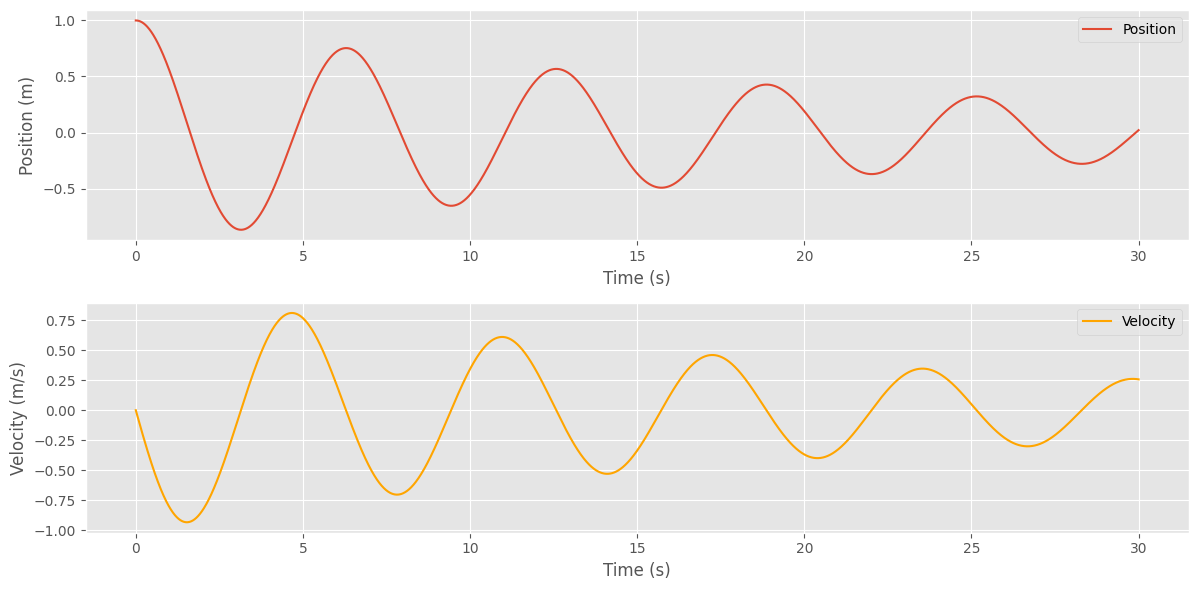

In [23]:
# Plotting the results
import matplotlib.pyplot as plt

plt.style.use("ggplot")

positions = states[:, 0]
velocities = states[:, 1]
time_points = jnp.arange(0, (num_steps + 1) * dt, dt)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_points, positions, label="Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_points, velocities, label="Velocity", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()

plt.tight_layout()
plt.show()

## Buidling Neiral Networks

In [24]:
import jax
import jax.numpy as jnp
from jax import grad, jit
from jax.random import PRNGKey, normal
import optax  # JAX's optimization library
import matplotlib.pyplot as plt


def init_layer_params(key, n_in, n_out):
    """Initialize parameters for a single dense layer"""
    key_w, key_b = jax.random.split(key)
    w = normal(key_w, (n_in, n_out)) * jnp.sqrt(2.0 / n_in)  # He initialization
    b = normal(key_b, (n_out,)) * 0.1
    return (w, b)


def relu(x):
    """ReLU activation function"""
    return jnp.maximum(0, x)


def forward(params, x):
    """Forward pass for a two-layer neural network"""
    (w1, b1), (w2, b2) = params
    # First layer
    h1 = relu(jnp.dot(x, w1) + b1)
    # Output layer
    logits = jnp.dot(h1, w2) + b2
    return logits


def loss_fn(params, x, y):
    """Mean squared error loss"""
    pred = forward(params, x)
    return jnp.mean((pred - y) ** 2)


def init_model(rng_key, input_dim, hidden_dim, output_dim):
    key1, key2 = jax.random.split(rng_key)
    params = [
        init_layer_params(key1, input_dim, hidden_dim),
        init_layer_params(key2, hidden_dim, output_dim),
    ]
    return params


@jit
def train_step(params, opt_state, x_batch, y_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, y_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


# Generate some example data
key = PRNGKey(0)
x_data = normal(key, (1000, 10))  # 1000 samples, 10 features
y_data = jnp.sum(x_data**2, axis=1, keepdims=True)  # Simple nonlinear function

# Initialize model and optimizer
params = init_model(key, input_dim=10, hidden_dim=32, output_dim=1)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Training loop
batch_size = 32
num_epochs = 100
num_batches = x_data.shape[0] // batch_size

# Arrays to store epoch and loss values
epoch_array = []
loss_array = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in range(num_batches):
        idx = jax.random.permutation(key, batch_size)
        x_batch = x_data[idx]
        y_batch = y_data[idx]
        params, opt_state, loss = train_step(params, opt_state, x_batch, y_batch)
        epoch_loss += loss

    # Store the average loss for the epoch
    avg_loss = epoch_loss / num_batches
    epoch_array.append(epoch)
    loss_array.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")


Epoch 0, Loss: 90.6157
Epoch 10, Loss: 5.1804
Epoch 20, Loss: 1.2572
Epoch 30, Loss: 0.5859
Epoch 40, Loss: 0.2757
Epoch 50, Loss: 0.1156
Epoch 60, Loss: 0.0477
Epoch 70, Loss: 0.0188
Epoch 80, Loss: 0.0062
Epoch 90, Loss: 0.0018


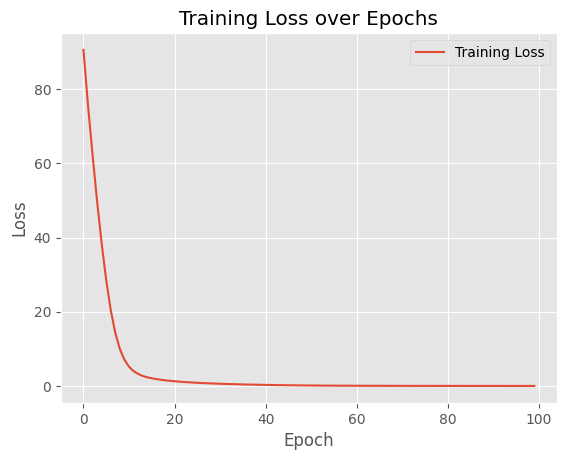

In [25]:
# Plot the results
plt.plot(epoch_array, loss_array, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

## Performance Optimization

In [26]:
import jax
import jax.numpy as jnp
from jax import jit
from jax import lax


# BAD: Dynamic Python control flow inside JIT
@jit
def bad_function(x, n):
    for i in range(n):  # Python loop - will be unrolled
        x = x + 1
    return x


print("===========================")
# print(bad_function(1, 1000)) # does not work


# GOOD: Use JAX-native operations
@jit
def good_function(x, n):
    return x + n  # Vectorized operation


print("===========================")
print(good_function(1, 1000))


# BETTER: Use scan for loops


@jit
def best_function(x, n):
    def body_fun(i, val):
        return val + 1

    return lax.fori_loop(0, n, body_fun, x)


print("===========================")
print(best_function(1, 1000))

1001
1001


In [27]:
from jax import debug


@jit
def debug_function(x):
    # Use debug.print instead of print inside JIT
    debug.print("Shape of x: {}", x.shape)
    y = jnp.sum(x)
    debug.print("Sum: {}", y)
    return y


# For more complex debugging, break out of JIT
def debug_values(x):
    print("Input:", x)
    result = debug_function(x)
    print("Output:", result)
    return result


print("===========================")
print(debug_function(jnp.array([1, 2, 3])))
print("===========================")
print(debug_values(jnp.array([1, 2, 3])))

Shape of x: (Array(3, dtype=int32),)
Sum: 6
6
Input: [1 2 3]
Shape of x: (Array(3, dtype=int32),)
Sum: 6
Output: 6
6


In [28]:
# 1. Device Memory Management
def process_large_data(data):
    # Process in chunks to manage memory
    chunk_size = 100
    results = []

    for i in range(0, len(data), chunk_size):
        chunk = data[i : i + chunk_size]
        chunk_result = jit(process_chunk)(chunk)
        results.append(chunk_result)

    return jnp.concatenate(results)


def process_chunk(chunk):
    chunk_temp = jnp.sqrt(chunk)
    return chunk_temp


print("===========================")
data = jnp.arange(10000)
print(data.shape)

print("===========================")
print(data)

print("===========================")
print(process_large_data(data))


(10000,)
[   0    1    2 ... 9997 9998 9999]
[ 0.         1.         1.4142135 ... 99.985     99.99      99.995    ]


In [29]:
# 2. Handling Random Seeds
def create_training_state(rng):
    # Split RNG for different uses
    rng, init_rng = jax.random.split(rng)
    params = init_network(init_rng)

    return params, rng  # Return new RNG for next use


def init_network(rng):
    # Initialize network parameters
    return {
        "w1": jax.random.normal(rng, (784, 256)),
        "b1": jax.random.normal(rng, (256,)),
        "w2": jax.random.normal(rng, (256, 10)),
        "b2": jax.random.normal(rng, (10,)),
    }


print("===========================")

key = jax.random.PRNGKey(0)
params, rng = create_training_state(key)


print(f"Random number generator: {rng}")

print(params.keys())

print("===========================")


print("===========================")
print(f"Network parameters shape: {params['w1'].shape}")

print("===========================")
print(f"Network parameters shape: {params['b1'].shape}")
print("===========================")
print(f"Network parameters shape: {params['w2'].shape}")

print("===========================")
print(f"Network parameters shape: {params['b2'].shape}")


print("===========================")
print(f"Network parameters: {params}")


Random number generator: [4146024105  967050713]
dict_keys(['w1', 'b1', 'w2', 'b2'])
Network parameters shape: (784, 256)
Network parameters shape: (256,)
Network parameters shape: (256, 10)
Network parameters shape: (10,)
Network parameters: {'w1': Array([[ 5.2278763e-01,  7.8880668e-02,  9.0638918e-01, ...,
         3.9273381e-01, -9.0940499e-01,  6.6453928e-01],
       [-7.9783428e-01,  1.9565071e+00, -3.0104196e-01, ...,
        -1.3077171e+00,  3.5896163e-02,  5.2602027e-02],
       [-2.3279522e-01, -1.8574070e+00,  1.6978498e-01, ...,
        -4.6157572e-01,  1.0614971e+00,  1.0927857e+00],
       ...,
       [ 1.1753079e-03, -9.2797303e-01, -3.4065768e-01, ...,
         7.8881347e-01,  1.8043330e+00, -3.4369582e-01],
       [ 5.2816564e-01, -1.4847070e+00,  1.2584126e+00, ...,
         2.3965056e-01, -1.0461185e+00, -4.7977254e-01],
       [-6.2744662e-02, -1.4540663e+00,  4.7088835e-01, ...,
        -9.5819747e-01, -1.2843794e+00, -2.2456572e+00]], dtype=float32), 'b1': Array([

In [30]:
def g(x, n):
    i = 0
    while i < n:
        i += 1
    return x + i


g_jit_correct = jax.jit(g, static_argnames=["n"])
print(g_jit_correct(10, 20))

30


In [31]:
from functools import partial


@partial(jax.jit, static_argnames=["n"])
def g_jit_decorated(x, n):
    i = 0
    while i < n:
        i += 1
    return x + i


print(g_jit_decorated(10, 20))

30


In [32]:
# # 3. Using static_argnums for dynamic shapes


# def f(x):
#     if x > 0:
#         return x
#     else:
#         return 2 * x


# @jit(f, static_argnums=(1,))  # Second argument won't be JIT-compiled
# def create_matrix(x, size):
#     return jnp.ones((size, size)) * x

In [33]:
# BAD: Creating large temporary arrays
@jit
def inefficient_function(x):
    temp1 = jnp.power(x, 2)  # Temporary array
    temp2 = jnp.sin(temp1)  # Another temporary
    return jnp.sum(temp2)


# GOOD: Combining operations
@jit
def efficient_function(x):
    return jnp.sum(jnp.sin(jnp.power(x, 2)))  # Single operation

In [35]:
x = jnp.array([1, 2, 3])
print(x)
print(inefficient_function(x))
print(efficient_function(x))

[1 2 3]
0.49678695
0.49678695
